In [2]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from VAINF.network import modeling
from torchvision.models import segmentation
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
class IDD(Dataset):
    root: str
    sample: float|None
    transform: transforms.Compose|None
    target_transform: transforms.Compose|None
    images: list[str]
    masks: list[str]

    CATEGORY_TO_LABEL: dict[str, int] = {
        "Road": 0, "Sidewalk": 2, "Person": 4, "Rider": 5, "Motorbike": 6,
        "Bicycle": 7, "Car": 9, "Truck": 10, "Bus": 11, "Train": 12,
        "Wall": 14, "Fence": 15, "Traffic Sign": 18, "Traffic Light": 19,
        "Pole": 20, "Building": 22, "Vegetation": 24, "Sky": 25, "Unlabeled": 255
    }

    LABEL_TO_CATEGORY: dict[int, str] = {mask: label for label, mask in CATEGORY_TO_LABEL.items()}

    LABEL_TO_COLOR: dict[int, tuple[int]] = {
        0: (128, 64, 128),  2: (244, 35, 232),  4: (220, 20, 60), 5: (255, 0, 0),
        6: (0, 0, 230),  7: (119, 11, 32), 9: (0, 0, 142), 10: (0, 0, 70),
        11: (0, 60, 100), 12: (0, 80,100), 14: (102, 102, 156), 15: (190, 153, 153),
        18: (220, 220, 0), 19: (250, 170, 30), 20: (153, 153, 153), 22: (70, 70, 70),
        24: (107, 142, 35), 25: (70, 130, 180),  255: (0, 0, 0)
    }

    CITYSCAPES_LABEL_TO_IDD_LABEL: dict[int, int] = {
        0: 0, 1: 2, 2: 22, 3: 14, 4: 15, 5: 20, 6: 19, 7: 18, 8: 24, 9: 255,
        10: 25, 11: 4, 12: 5, 13: 9, 14: 10, 15: 11, 16: 12, 17: 6, 18: 7,
        255: 255
    }

    CITYSCAPES_COLOR_TO_CITYSCAPES_LABEL: dict[tuple[int], int] = {
        (0, 0, 0): 255, (111, 74, 0): 255, (81, 0, 81): 255, (128, 64, 128): 0, (244, 35,232): 1,
        (250, 170, 160): 255, (230, 150, 140): 255, (70, 70, 70): 2, (102, 102, 156): 3,
        (190, 153, 153): 4, (180, 165, 180): 255, (150, 100, 100): 255, (150, 120, 90): 255,
        (153, 153, 153): 5, (250, 170, 30): 6, (220, 220, 0): 7, (107, 142, 35): 8,
        (152, 251, 152): 9, (70, 130, 180): 10, (220, 20, 60): 11, (255, 0, 0): 12,
        (0, 0, 142): 13, (0, 0, 70): 14, (0, 60, 100): 15, (0, 0, 90): 255, (0, 0, 110): 255,
        (0, 80, 100): 16, (0, 0, 230): 17, (119, 11, 32): 18, (0, 0, 142): 13
    }

    def __init__(self, root, sample=1.0, shuffle=False, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        images = os.path.join(root, "image_archive")
        masks = os.path.join(root, "mask_archive")
        self.images = [os.path.join(images, image) for image in sorted(os.listdir(images), key=lambda f: int(f.split("_")[-1][:-4]))]
        self.masks = [os.path.join(masks, mask) for mask in sorted(os.listdir(masks), key=lambda f: int(f.split("_")[-1][:-4]))]
        size = int(sample * len(self.images))
        if shuffle:
            indices = torch.randperm(len(self.images))[:size]
        else:
            indices = torch.arange(len(self.images))[:size]
        self.images = [self.images[i] for i in indices]
        self.masks = [self.masks[i] for i in indices]

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        return image, mask

    @staticmethod
    def convert_to_IDD(mask: torch.Tensor) -> None:
        mask.map_(mask, lambda index, value: IDD.CITYSCAPES_LABEL_TO_IDD_LABEL.get(value, 255))

    @staticmethod
    def color_mask(mask: torch.Tensor, scheme: str = "idd", highlight: str|None = None) -> torch.Tensor:
        if scheme == "cityscapes":
            IDD.convert_to_IDD(mask)
        colored_mask = torch.zeros(*mask.shape, 3, dtype=torch.uint8)
        for label, color in IDD.LABEL_TO_COLOR.items():
            if highlight is not None:
                color = color if IDD.CATEGORY_TO_LABEL.get(highlight) == label else (100, 100, 100)
            colored_mask[mask == label] = torch.tensor(color, dtype=torch.uint8)
        return colored_mask

In [3]:
class PILToTensor:
    def __call__(self, image):
        image = torch.as_tensor(np.array(image), dtype=torch.uint8)
        return image

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    PILToTensor()
])

root = r"Datasets/Indian Driving Dataset"
dataset = IDD(root=root, sample=0.3, shuffle=True, transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=2)
NUM_BATCHES: int = len(dataloader)

In [4]:
mask_tensors = torch.tensor([])
for i in range(5):
    image, mask = dataset[i]
    mask_tensors = torch.cat((mask_tensors, mask.view(-1)), dim=0)
print()
print(mask_tensors.shape)


torch.Size([1310720])


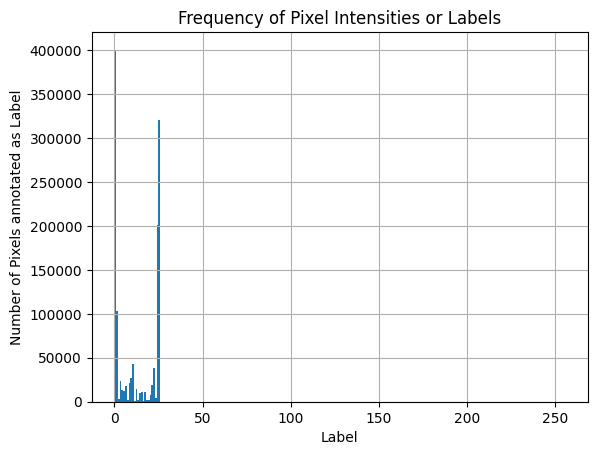

In [5]:
plt.title("Frequency of Pixel Intensities or Labels")
plt.hist(mask_tensors.ravel(), 256, [0, 256])
plt.xlabel("Label")
plt.ylabel("Number of Pixels annotated as Label")
plt.grid(True)
plt.show()

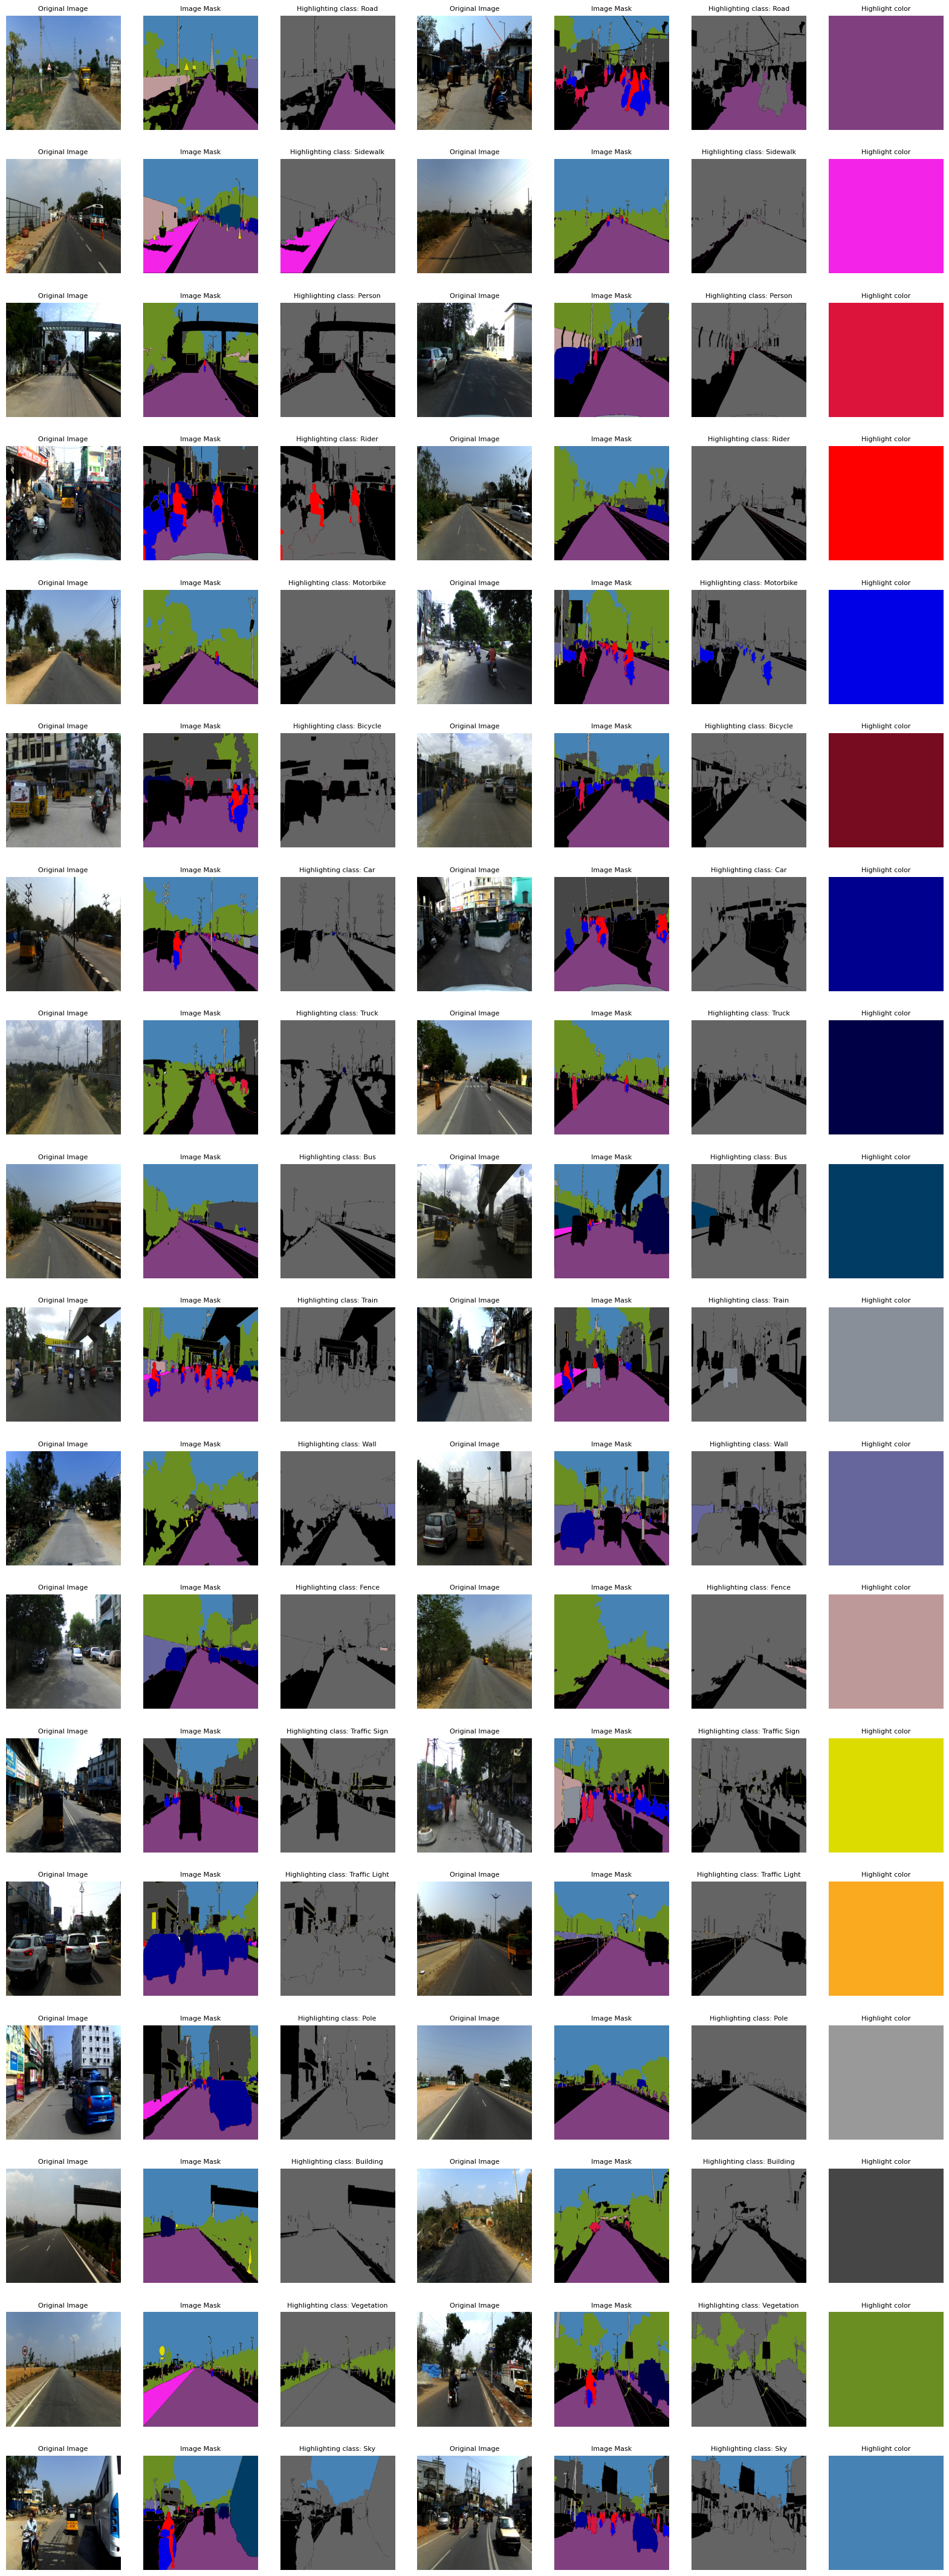

In [7]:
fig, axes = plt.subplots(18, 7, figsize=(20, 55))
index = -1
for i, (category, label) in enumerate(IDD.CATEGORY_TO_LABEL.items()):
    if label == 255: continue
    j = 0
    color = IDD.LABEL_TO_COLOR.get(label)
    colorbox = torch.tensor(color, dtype=torch.uint8).unsqueeze(0).unsqueeze(0)
    for _ in range(2):
        image, mask = dataset[(index := index+1)]
        while torch.bincount(mask.flatten())[label] < 0.001 * 512**2:
            image, mask = dataset[(index := index+1)]
            print(f"Finding {category}".ljust(50), end="\r")
        axes[i, j].set_title("Original Image", fontsize=8)
        axes[i, j].imshow(image.permute(1, 2, 0))
        axes[i, j].axis("off")
        j += 1
        axes[i, j].set_title("Image Mask", fontsize=8)
        axes[i, j].imshow(IDD.color_mask(mask))
        axes[i, j].axis("off")
        j += 1
        axes[i, j].set_title(f"Highlighting class: {category}", fontsize=8)
        axes[i, j].imshow(IDD.color_mask(mask, highlight=category))
        axes[i, j].axis("off")
        j += 1
    axes[i, j].set_title("Highlight color", fontsize=8)
    axes[i, j].imshow(colorbox.repeat(512, 512, 1, 1).reshape(512, 512, 3))
    axes[i, j].axis("off")
plt.show()

In [8]:
device = torch.device("cuda:0")
deeplab_model = modeling.__dict__["deeplabv3plus_resnet101"](num_classes=19, output_stride=8)
deeplab_model.load_state_dict(torch.load("DeepLabV3Plus-Resnet101.pth.tar", map_location=device)["model_state"])
deeplab_model.to(device)
deeplab_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [56]:
for batch, (images, masks) in tqdm(enumerate(dataloader)):
    with torch.no_grad():
        images = images.to(device)
        outputs = deeplab_model(images)
        predictions = outputs.max(1)[1].detach().reshape(-1, 512, 512)
        torch.save(images, f"cv-segmentation-outputs/Images/Batch-{batch}.torch")
        torch.save(masks, f"cv-segmentation-outputs/Masks/Batch-{batch}.torch")
        IDD.convert_to_IDD(predictions.to("cpu"))
        torch.save(predictions, f"cv-segmentation-outputs/Predictions/Batch-{batch}.torch")
    del images
    del outputs
    torch.cuda.empty_cache()